## Importando dependências

In [1]:
# pip install tensorflow sklearn

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.metrics import Precision
from tensorflow.keras.metrics import Recall
from tensorflow.keras.metrics import Accuracy
from tensorflow.keras.losses import Loss
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils import shuffle
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import RandomOverSampler

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


## Importando dataset e splitando em teste e treino

In [3]:
def normalize_dataset_labels(dataset):
    y = dataset.iloc[:, -1].values
    unique_labels = sorted(list(set(y)))
    for i in range(len(y)):
        y[i] = unique_labels.index(y[i])

    dataset.iloc[:, -1] = y

HEADER = ["timestamp",'srcip', 'srcport', 'dstip', 'dstport', 'proto', 'total_fpackets', 'total_fvolume',
          'total_bpackets', 'total_bvolume', 'min_fpktl', 'mean_fpktl', 'max_fpktl', 'std_fpktl', 'min_bpktl',
          'mean_bpktl', 'max_bpktl', 'std_bpktl', 'min_fiat', 'mean_fiat', 'max_fiat', 'std_fiat', 'min_biat',
          'mean_biat', 'max_biat', 'std_biat', 'duration', 'min_active', 'mean_active', 'max_active', 'std_active',
          'min_idle', 'mean_idle', 'max_idle', 'std_idle', 'sflow_fpackets', 'sflow_fbytes', 'sflow_bpackets',
          'sflow_bbytes', 'fpsh_cnt', 'bpsh_cnt', 'furg_cnt', 'burg_cnt', 'total_fhlen', 'total_bhlen', "dscp", 'class']
initial_dataset = pd.read_csv('dataset-oi-2017-02-24.csv', names=HEADER)

# initial_dataset = balance_dataset_labels(initial_dataset)

normalize_dataset_labels(initial_dataset)

## Criando modelo do cliente

In [100]:
class Client:
    def __init__(self, client_id = 123, dataset = [1.0, 2.0]):
        self.client_id = client_id
        self.local_dataset = pd.DataFrame(dataset)
        self.local_tree = DecisionTreeClassifier(random_state=0, max_depth=35, criterion='entropy')
        self.metrics_history = list()
        self.local_forest = [self.local_tree]
        
        
    def preprocess(self):
        X = self.local_dataset.iloc[:, 5:-1].values
        y = self.local_dataset.iloc[:, -1].values
        
        X = np.array(X, dtype=np.float64)
        y = np.array(y, dtype=np.float64)
        
        sc = StandardScaler()
        X = sc.fit_transform(X)
        
#         oversample = RandomOverSampler()
#         X, y = oversample.fit_resample(X, y)
        
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)
        
    def train_tree(self):
        # depth 35 é o melhor
#         params = {'max_depth': [15,20,30,35,40]}

#         gcv = GridSearchCV(estimator=self.local_tree,param_grid=params)
#         gcv.fit(self.X_train, self.y_train)
#         self.local_tree = gcv.best_estimator_

        self.local_tree.fit(self.X_train, self.y_train)
        
    def test_tree(self):
        y_pred = self.local_tree.predict(self.X_test)
        
#         precision = Precision()
#         precision.update_state(self.y_test, y_pred)
#         prec = precision.result().numpy()
        
#         recall = Recall()
#         recall.update_state(self.y_test, y_pred)
#         rec = recall.result().numpy()
        
        self.local_score = self.local_tree.score(self.X_test, self.y_test)
        print(f"[INFO] Accuracy of client {self.client_id} = {self.local_score}")
        
        self.metrics_history.append((acc, 0.0, 0.0))
#         cm = confusion_matrix(self.y_test, y_pred)
#         print(cm)  

## Splitando dataset para os clientes da rede

In [101]:
num_clients = 20
max_num_trees = 10
clients = [Client(client_id = i) for i in range(num_clients)]

# pega os N primeiros clientes com mais dados e que possuem dataset com > 1 classe
unique_ips = initial_dataset['srcip'].value_counts().head(num_clients + 10).keys()
client_index, i = (0,0)
while client_index < num_clients:
    local_dataset = initial_dataset.loc[initial_dataset['srcip'] == unique_ips[i]]
    num_classes = len(local_dataset['class'].value_counts())
    if num_classes > 1:
        clients[client_index].local_dataset = local_dataset
        client_index += 1
    i += 1
        

## Treinando e testando modelos DT locais

In [102]:
for client in clients:
    client.preprocess()
    client.train_tree()
    client.test_tree()

print("[INFO] All local trains are finished!")

[INFO] Accuracy of client 0 = 0.9356502850936737
[INFO] Accuracy of client 1 = 0.8437007063987381
[INFO] Accuracy of client 2 = 0.9997739431843871
[INFO] Accuracy of client 3 = 0.8649109511178477
[INFO] Accuracy of client 4 = 0.8667617689015692
[INFO] Accuracy of client 5 = 0.7890216078378741
[INFO] Accuracy of client 6 = 0.9312517118597644
[INFO] Accuracy of client 7 = 0.9991031390134529
[INFO] Accuracy of client 8 = 0.819626168224299
[INFO] Accuracy of client 9 = 0.999656652360515
[INFO] Accuracy of client 10 = 0.9996395746981438
[INFO] Accuracy of client 11 = 0.9993734335839599
[INFO] Accuracy of client 12 = 0.9995279679018173
[INFO] Accuracy of client 13 = 1.0
[INFO] Accuracy of client 14 = 0.9997095556200988
[INFO] Accuracy of client 15 = 1.0
[INFO] Accuracy of client 16 = 1.0
[INFO] Accuracy of client 17 = 1.0
[INFO] Accuracy of client 18 = 0.999349593495935
[INFO] Accuracy of client 19 = 0.9830120875530872
[INFO] All local trains are finished!


## Compartilhando DTs e atualizando FedForest

In [103]:
for current in range(num_clients):
    appended_trees, replaced_trees, acc_list = (0,0,[])
    for neighbour in range(num_clients):
        if current != neighbour:
            neighbour_tree = clients[neighbour].local_tree
            acc = neighbour_tree.score(clients[current].X_test, clients[current].y_test)
            
            if len(clients[current].local_forest) < max_num_trees:
                clients[current].local_forest.append(neighbour_tree)
                acc_list.append(acc)
                appended_trees += 1
            else:
                min_acc = min(acc_list)
                min_index = acc_list.index(min_acc) # seleciona a árvore de menor acurácia
                if min_acc < acc:
                    clients[current].local_forest[min_index] = neighbour_tree # substitui a árvore pela nova
                    acc_list[min_index] = acc
                    replaced_trees += 1
    print(f"Client {current} appended {appended_trees} and replaced {replaced_trees} trees to forest")
    print(f"{acc_list}\n")
                

Client 0 appended 9 and replaced 9 trees to forest
[0.8766766223187619, 0.8766766223187619, 0.8766766223187619, 0.876350800977464, 0.87645940809123, 0.8747759978278578, 0.8766766223187619, 0.876296497420581, 0.8724952484387727]

Client 1 appended 9 and replaced 8 trees to forest
[0.5431726219052191, 0.49118716137439133, 0.49118716137439133, 0.49118716137439133, 0.49118716137439133, 0.4911185789726356, 0.4907070845621014, 0.4970166655236266, 0.4908442493656128]

Client 2 appended 9 and replaced 9 trees to forest
[0.9961570341345791, 0.9907316705598673, 0.998945068193806, 0.9993218295531611, 0.99924647728129, 0.9993218295531611, 0.9928415341722553, 0.9969859091251602, 0.9944239318815462]

Client 3 appended 9 and replaced 5 trees to forest
[0.40015157256536565, 0.6190791966654036, 0.3956991284577491, 0.526335733232285, 0.3956043956043956, 0.5326828344069723, 0.3956991284577491, 0.5673550587343691, 0.3956991284577491]

Client 4 appended 9 and replaced 8 trees to forest
[0.7170708511650024,

## Testando a RF dos clientes

In [104]:
import statistics
from joblib import Parallel, delayed
from statistics import mode

def forest_predict(forest, X):
    forest_prediction = list()
    for row in X:
        tree_predictions = list()
        for tree in forest:
            tree_predictions.append(tree.predict([row])[0])
        forest_prediction.append(mode(tree_predictions))
    return forest_prediction

for client in clients:
    accuracy = Accuracy()
    forest_pred = forest_predict(client.local_forest, client.X_test)
    accuracy.update_state(client.y_test, forest_pred)
    acc = accuracy.result().numpy()
    
    print(f"Accuracy for client {client.client_id} forest = {acc}")

Accuracy for client 0 forest = 0.876676619052887
Accuracy for client 1 forest = 0.4911871552467346
Accuracy for client 2 forest = 0.9993218183517456
Accuracy for client 3 forest = 0.3956991136074066
Accuracy for client 4 forest = 0.7170708775520325
Accuracy for client 5 forest = 0.34277278184890747
Accuracy for client 6 forest = 0.8323746919631958
Accuracy for client 7 forest = 0.9913303256034851
Accuracy for client 8 forest = 0.686604380607605
Accuracy for client 9 forest = 0.9960514903068542
Accuracy for client 10 forest = 0.9992791414260864
Accuracy for client 11 forest = 0.999791145324707
Accuracy for client 12 forest = 0.9818267822265625
Accuracy for client 13 forest = 0.9939655065536499
Accuracy for client 14 forest = 0.9997095465660095
Accuracy for client 15 forest = 0.9970466494560242
Accuracy for client 16 forest = 0.9787106513977051
Accuracy for client 17 forest = 0.9974424839019775
Accuracy for client 18 forest = 0.9983739852905273
Accuracy for client 19 forest = 0.828160703

## Plotando resultados dos treinos locais

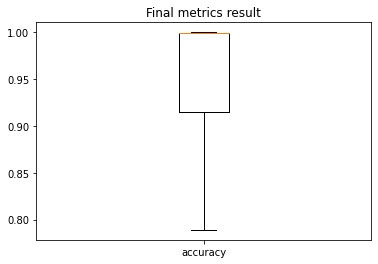

In [106]:
final_metrics = []
for client in clients:
    final_metrics.append(client.local_score)

plt.boxplot(final_metrics)
plt.title('Final metrics result')
plt.xticks([1], ['accuracy'])
plt.show()